# ADT

In [8]:
import os
import sys

import pickle
import numpy as np
import glob

import warnings # ignore tensorflow warinings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from keras import backend as K
import soundfile as psf

sys.path.append('models')
from large_vocab_adt_dafx2018.transcribe import transcribe, PERC_VOICE_SET
import large_vocab_adt_dafx2018.model as model

# pip install pyrsistent==0.16.1

## Download Groove MIDI Dataset

In [13]:
# DOWNLOAD GROOVE MIDI DATASET
import requests, zipfile, io

groove_path = 'groove/'

# if dir exists and is empty, remove
if os.path.exists(groove_path) and os.listdir(groove_path)==0:
    os.removedirs(groove_path)

# if dir does not exist, download dataset
if not os.path.exists(groove_path):
    r = requests.get(zip_file_url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall("./")

## Compute ADT to 8 voices

In [16]:
models_path = 'models/large_vocab_adt_dafx2018/trained_models/'

# load model
model_definition_path = os.path.join(models_path,'303_s0_def.json')
model_weights_path = os.path.join(models_path,'303_s0_weights.h5')
model_configuration_id = 303
sample_audio_files = dict([(v, os.path.join('models/audio/', '{}.wav'.format(v))) for v in PERC_VOICE_SET])

# audio file
input_audio_file = 'groove/drummer1/session1/1_funk_80_beat_4-4.wav'

# compute model's onsets >> outputs 14 voices
output = transcribe(model_definition_path,
                    model_weights_path,
                    input_audio_file,
                    model_configuration_id,
                    sample_audio_files,
                    peak_params=None,
                    output_sample_rate=44100)

# save into out_14v
out_14v = output['14v']['onset_activations']

Single output


Since the model outputs 14 voices, we need to reduce them to the 8 ones present in the magenta dataset. In the magenta dataset there's actually 9 but one has no correspondence with the ones that this model outputs, so I removed it

In [59]:
# reduce 14 voices to the 8 present in the magenta dataset

length_in_samples = model_14v.shape[0]
out_8v = np.zeros([length_in_samples,8])

reduced_mapping = {
    0: [0],     # kick
    1: [1,2],   # snare + snare rim 
    2: [3],     # crash
    3: [4,12],  # ride + bell
    4: [5],     # open hh
    5: [6],     # closed hh
    6: [7,8],   # low+mid tom
    7: [9]      # high tom
}


eps = 0 # threshold ?

for t in range(length_in_samples):
    t_roll = model_14v[t,:]
    t_roll[t_roll<eps] = 0
    for i in reduced_mapping.keys():
        out_8v[t,i] = np.max(t_roll[reduced_mapping[i]])

## Extract onsets from midi file

In [27]:
import pretty_midi

# same as audio file but changing .wav to .mid
input_midi_file = input_audio_file.split('.')[-2] + '.mid'
midi_data = pretty_midi.PrettyMIDI(input_midi_file)

# extract onsets from midi file with midi_data.get_onsets()
onsets = midi_data.get_onsets()

In [68]:
# get pretty_midi Notes objects in a list
drums_notes = midi_data.instruments[0].notes[:]

drums_onsets = []
drums_instrument = []

for note in drums_notes:
    drums_onsets.append(note.start)    # onsets list
    drums_instrument.append(note.pitch)   # instrument  

drums_onsets = np.round(drums_onsets,2)   # in seconds
drums_onsets = np.round(drums_onsets/0.01,0) # in samples


In [69]:
# map to 8 voices

magenta_mapping = { # [key, [pitches]]
    "kick":[0,[36]],
    "snare":[1,[38,40,37]],
    "crash":[2,[49,55,57,52]],
    "ride":[3,[51,59,53]],
    "open_hh":[4,[46,26]],
    "closed_hh":[5,[42,22,44]],
    "low_mid_tom":[6,[45,47]],
    "high_tom":[7,[48,50]]
}

magenta_transcription = np.zeros([length_in_samples,8])

for onset,inst in zip(drums_onsets,drums_instrument):
    onset = int(onset)
    
    # map pretty_midi pitch to magenta pitch value
    for magenta_inst in magenta_mapping.keys():
        
        if inst in magenta_mapping[magenta_inst][1]:
            magenta_transcription[onset][magenta_mapping[magenta_inst][0]] = 1

# Plot

In [84]:
import matplotlib.pyplot as plt
import librosa.display

%matplotlib inline

def plot_activations(X, start_s, stop_s, sample_interval, sr=44100, size=(15,5)):
    sample_interval = int(round(sample_interval * sr)) / float(sr)
    hop_length = int(sample_interval * sr)
    start_idx = int(start_s / sample_interval)
    stop_idx = int(stop_s / sample_interval)
    plt.figure(figsize=size)
    librosa.display.specshow(X[start_idx:stop_idx,:].T, 
                             sr=sr, 
                             hop_length=hop_length,
                             x_axis='time')
        
    labels = ['Kick Drum', # 0
                  'Snare', # 1 Snare + Snare Rim
                  'Crash', # 2
                  'Ride', # 3 Ride + Bell
                  'Open Hi-Hat', # 4
                  'Closed Hi-Hat', # 5
                  'Low-Mid Tom', # 6 Low + Mid
                  'High Tom'] # 7
     
    plt.yticks(np.arange(X.shape[1]) + 0.5, labels)

# Plot activations

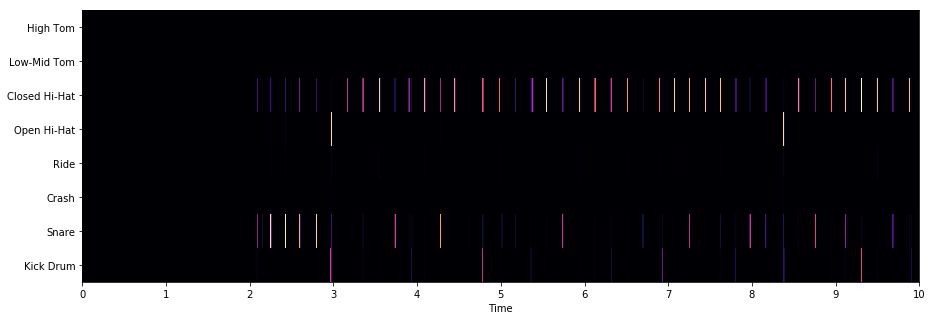

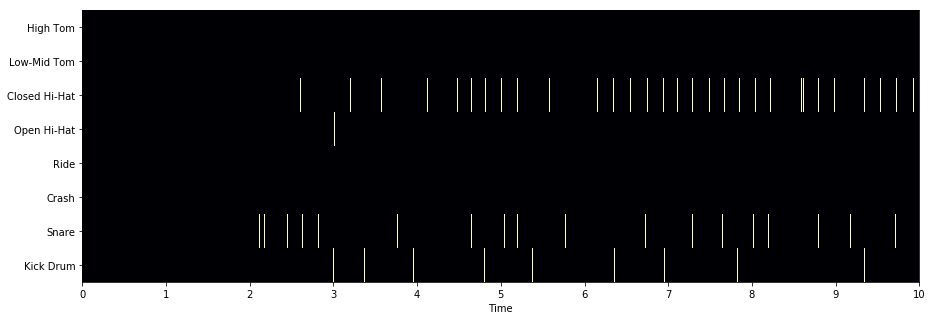

In [83]:
plot_activations(out_8v, 0, 10, 0.01)
plot_activations(magenta_transcription,0,10,0.01)

# Evaluation
para hacer la evaluación hay q pasar un array de los onsets en segundos

In [53]:
import mir_eval
onsets_eval_magenta = np.arange(length_in_samples)*magenta_transcription[:,0]*0.01
#model_8v[model_8v<0.5] = 0
#model_8v = model_8v[model_8v!=0]
simp_model = out_8v;
simp_model[simp_model<0.01] = 0

onsets_eval_magenta = np.sort(onsets_eval_magenta[onsets_eval_magenta!=0])

onsets_eval_model = np.arange(length_in_samples)*simp_model[:,0]*0.01
onsets_eval_model = np.sort(onsets_eval_model[onsets_eval_model!=0])
print(len(onsets_eval_model),len(onsets_eval_magenta))
print(onsets_eval_model[0:100])
mir_eval.onset.validate(onsets_eval_magenta,onsets_eval_model)
mir_eval.onset.f_measure(onsets_eval_magenta,onsets_eval_model, window=0.05)

(407, 120)
[0.05557268 0.05774906 0.05815276 0.06848445 0.06857081 0.07174249
 0.07370358 0.0738991  0.07510225 0.07724554 0.08049838 0.08966239
 0.09538527 0.09574794 0.09589703 0.09775061 0.10538893 0.10754065
 0.11122363 0.11430717 0.1163701  0.11935682 0.13362081 0.13795494
 0.14324968 0.15956778 0.17960746 0.18522495 0.18669159 0.1932326
 0.19425934 0.19497629 0.20290852 0.20431392 0.2077242  0.21022773
 0.21037649 0.21627357 0.21921615 0.22959979 0.23353769 0.23771664
 0.24988871 0.25050555 0.26119082 0.26407671 0.26598686 0.26976829
 0.2836882  0.28393181 0.28395412 0.28725044 0.28914706 0.29100389
 0.291051   0.29165755 0.29276038 0.29428126 0.297491   0.29979478
 0.3112837  0.31268605 0.32005883 0.32550344 0.3258742  0.33019991
 0.33625511 0.35005133 0.36390157 0.36431793 0.3644125  0.3793756
 0.38156945 0.38628861 0.39232131 0.39919632 0.40279011 0.40599476
 0.40830552 0.41947692 0.42897011 0.42901819 0.43129093 0.43176854
 0.4373814  0.43858734 0.44330537 0.45836376 0.463804

(0.060721062618595834, 0.03931203931203931, 0.13333333333333333)

## Helpers

In [9]:
# HELPERS 
#from utils import read_audio
#input_audio_file = '1_rock_87_beat_4-4.wav'
#x,sr= read_audio('1_rock_87_beat_4-4.wav')
#print(len(x)/sr)

# Model 303 is the Small, Multi-task model trained on real + synth, with classes weighted by entropy
#
# Other models:
# MT-S-R (289)
# MT-S-S (290)
# MT-S-R+S (291)
# MT-L-R (292)
# MT-L-S (293)
# MT-L-R+S (294)
# 14VST-S-R+S (295)
# 3VST-S-R+S (301)
# BTST-S-R+S (302)
# 14VST-S-R+S-Eweight (303)

In [20]:
"""
failing
# reduce 14 voices to the 8 present in the magenta dataset

length_in_samples = model_14v.shape[0]
model_8v = np.zeros([timefrs,8])

reduced_mapping = {
    "kick": [0,[0]],     # kick
    "snare": [1,[1,2]],   # snare + snare rim 
    "crash": [2,[3]],     # crash
    "ride": [3,[4,12]],  # ride + bell
    "open_hh": [4,[5]],     # open hh
    "closed_hh": [5,[6]],     # closed hh
    "low_mid_tom": [6,[7,8]],   # low+mid tom
    "high_tom": [7,[9]]      # high tom
}


eps = 0 #threshold ?
for t in range(timefrs):
    t_roll = model_14v[t,:]
    t_roll[t_roll<eps] = 0
    for i,inst in enumerate(reduced_mapping.keys()):
        model_8v[t,i] = np.max(t_roll[reduced_mapping[inst][1]])

"""

'\nfailing\n# reduce 14 voices to the 8 present in the magenta dataset\n\nlength_in_samples = model_14v.shape[0]\nmodel_8v = np.zeros([timefrs,8])\n\nreduced_mapping = {\n    "kick": [0,[0]],     # kick\n    "snare": [1,[1,2]],   # snare + snare rim \n    "crash": [2,[3]],     # crash\n    "ride": [3,[4,12]],  # ride + bell\n    "open_hh": [4,[5]],     # open hh\n    "closed_hh": [5,[6]],     # closed hh\n    "low_mid_tom": [6,[7,8]],   # low+mid tom\n    "high_tom": [7,[9]]      # high tom\n}\n\n\neps = 0 #threshold ?\nfor t in range(timefrs):\n    t_roll = model_14v[t,:]\n    t_roll[t_roll<eps] = 0\n    for i,inst in enumerate(reduced_mapping.keys()):\n        model_8v[t,i] = np.max(t_roll[reduced_mapping[inst][1]])\n\n'